# **Traffic Sign Recognition with Gluon**

## **About DataSet**

### **Belgium Traffic Sign Dataset**
---
Dataset can be obtained from [HERE](http://btsd.ethz.ch/shareddata/).


There are huge datasets, but all we need are only two of those.
- BelgiumTSG_Training(171.3MBytes)
- BelgiumTSC_Testing(76.5Mbytes)



This tutorial uses these two paths:

    /traffic/datasets/BelgiumTS/Training/
    /traffic/datasets/BelgiumTS/Testing/

Each of the two directories contain 62 subdirectories, named sequentially from **00000** to **00061**. The directory names represent the labels, and the images inside each directory are samples of each label.

### **Exploring the Dataset**


In [8]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn, rnn
from tqdm import tqdm
from mxnet import  autograd
from sklearn.model_selection import StratifiedShuffleSplit

# Allow image embeding in notebook
%matplotlib inline

In [9]:
train_data_dir = '/Users/junui/traffic/datasets/BelgiumTS/Training/'
test_data_dir = '/Users/junui/traffic/datasets/BelgiumTS/Testing/'

#### **Load Images**

In [10]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

train_images, train_labels = load_data(train_data_dir)
test_images, test_labels = load_data(test_data_dir)

In [11]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(train_labels)), len(train_images)))
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(test_labels)), len(test_images)))

Unique Labels: 62
Total Images: 4575
Unique Labels: 53
Total Images: 2520


#### **Display Images**

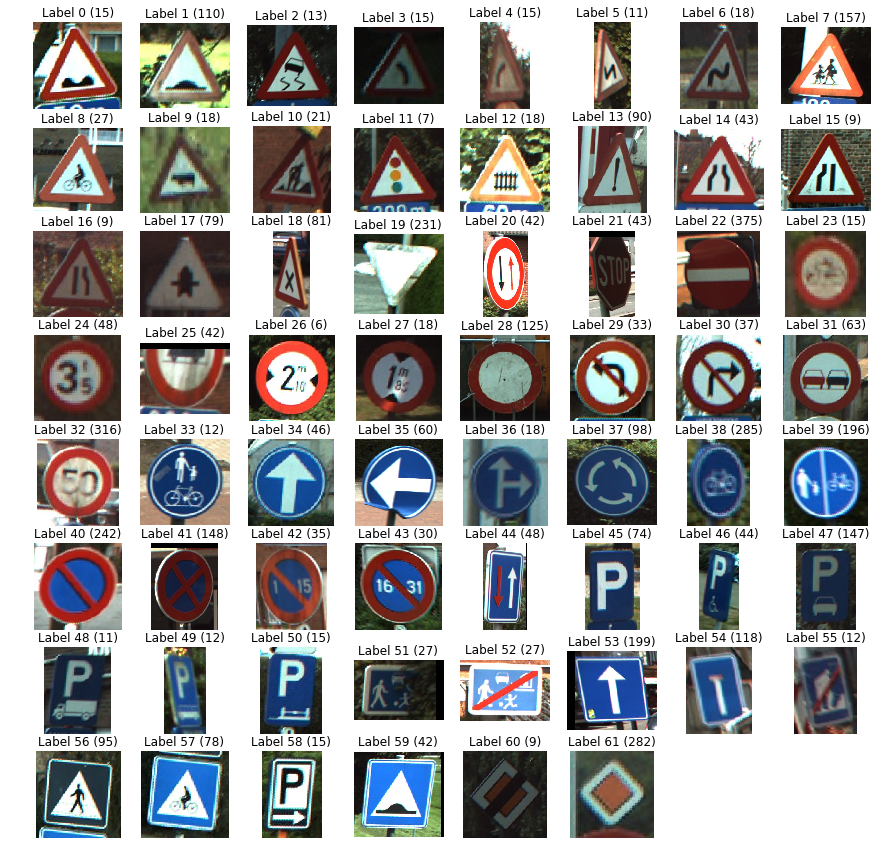

In [12]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(train_images, train_labels)

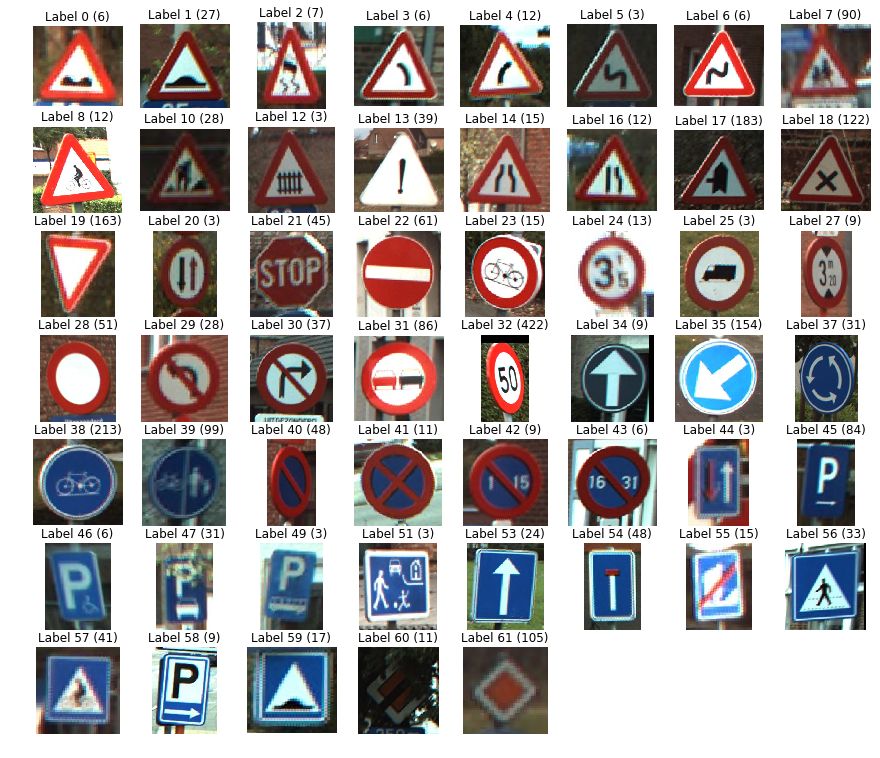

In [13]:
display_images_and_labels(test_images, test_labels)

#### **Display Images with Label**

In [280]:
train_labels.asnumpy().tolist().index(0)

99

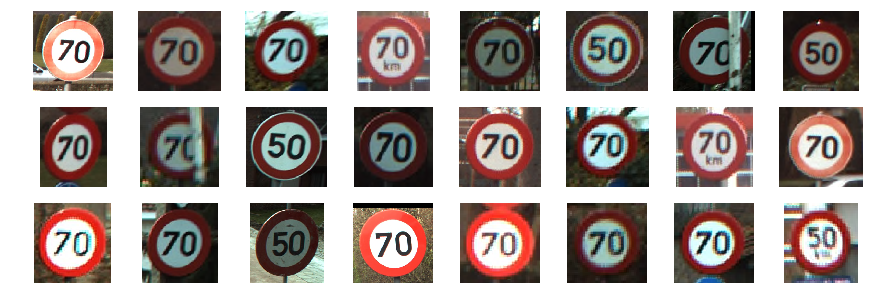

In [14]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = train_labels.index(label)
    end = start + train_labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(test_images, 30)

#### **Handling Image's Size**

In [15]:
for image in test_images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (112, 117, 3), min: 16, max: 255
shape: (91, 92, 3), min: 5, max: 254
shape: (141, 143, 3), min: 0, max: 255
shape: (48, 48, 3), min: 0, max: 255
shape: (86, 85, 3), min: 0, max: 255


/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


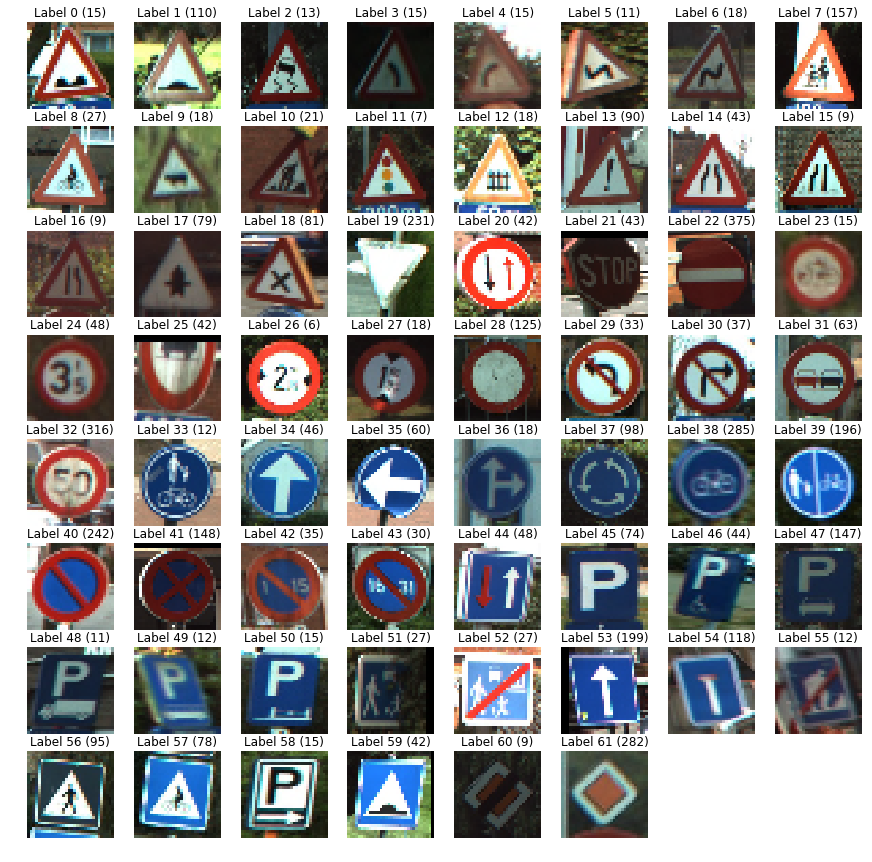

In [16]:
# Resize Images
train_images32 = [skimage.transform.resize(image, (32, 32))
                for image in train_images]
test_images32 = [skimage.transform.resize(image, (32, 32))
                for image in test_images]
display_images_and_labels(train_images32, train_labels)

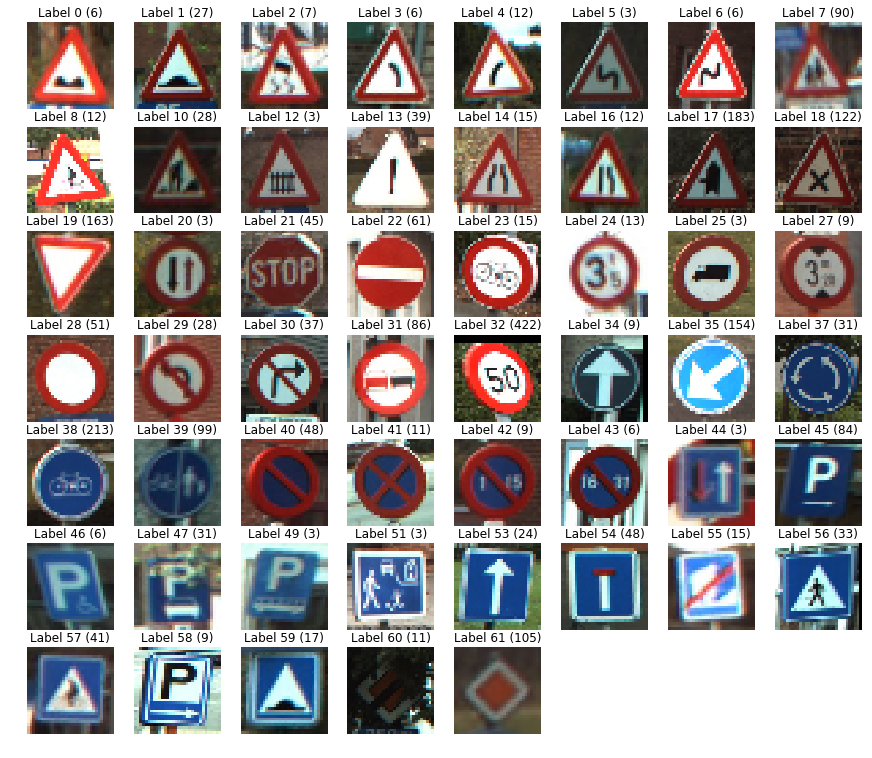

In [18]:
display_images_and_labels(test_images32, test_labels)

### **Preprocessing**

In [19]:
print(mx.nd.array(train_images32).shape)
print(mx.nd.transpose(mx.nd.array(train_images32).astype('float32'), (0, 3, 1, 2)).shape)

(4575, 32, 32, 3)
(4575, 3, 32, 32)


In [20]:
train_images32_t = mx.nd.transpose(mx.nd.array(train_images32).astype('float32'), (0, 3, 1, 2))
test_images32_t = mx.nd.transpose(mx.nd.array(test_images32).astype('float32'), (0, 3, 1, 2))
train_labels = mx.nd.array(train_labels)
test_labels = mx.nd.array(test_labels)
print(train_images32_t.shape)
print(test_images32_t.shape)
print(train_labels.shape)
print(test_labels.shape)

(4575, 3, 32, 32)
(2520, 3, 32, 32)
(4575,)
(2520,)


In [21]:
print(gluon.data.ArrayDataset(train_images32_t, train_labels)[0][0])
print(gluon.data.ArrayDataset(train_images32_t, train_labels)[0][1])
print(gluon.data.ArrayDataset(test_images32_t, test_labels)[0][0])
print(gluon.data.ArrayDataset(test_images32_t, test_labels)[0][1])


[[[ 0.21147366  0.42470893  0.45133272 ...,  0.25713849  0.2369179
    0.28457415]
  [ 0.21328124  0.43465075  0.43924633 ...,  0.33166361  0.28051472
    0.26593137]
  [ 0.25265011  0.4577359   0.4636642  ...,  0.34082416  0.31960785
    0.31660539]
  ..., 
  [ 0.38538602  0.43543199  0.43636641 ...,  0.17899816  0.18233763
    0.09048713]
  [ 0.44431677  0.39443934  0.39247856 ...,  0.17570466  0.14019608
    0.10951287]
  [ 0.45226717  0.3942402   0.37415749 ...,  0.17840074  0.13909313
    0.12686887]]

 [[ 0.3817555   0.53941482  0.56490505 ...,  0.27728248  0.26960784
    0.32734376]
  [ 0.37778798  0.55677086  0.54105395 ...,  0.34446996  0.32094055
    0.30957416]
  [ 0.43086705  0.5807445   0.546875   ...,  0.29733455  0.28769913
    0.29191175]
  ..., 
  [ 0.51285231  0.56484377  0.55879289 ...,  0.17017463  0.17100184
    0.08195466]
  [ 0.55546874  0.51176471  0.5066483  ...,  0.16403186  0.12189032
    0.09204964]
  [ 0.55425858  0.49010417  0.47317708 ...,  0.17118566  0

In [22]:
train_set = gluon.data.ArrayDataset(train_images32_t, train_labels)
test_set = gluon.data.ArrayDataset(test_images32_t, test_labels)

In [23]:
test_set_iter  = gluon.data.DataLoader(test_set,  batch_size=120, shuffle=True)
train_set_iter = gluon.data.DataLoader(train_set, batch_size=120, shuffle=True)

In [24]:
for i, (data_x, data_y) in enumerate(train_set_iter):
    data_set_x = data_x
    data_set_y = data_y
    break

### **Define Network Architecture**

In [25]:
class traffic(gluon.Block):
    def __init__(self, **kwargs):
        super(traffic, self).__init__(**kwargs)
        with self.name_scope():
            self.conv0 = nn.Conv2D(channels=64, kernel_size=5, activation='relu')
            self.maxpool = nn.MaxPool2D()
            self.conv1 = nn.Conv2D(channels=128, kernel_size=3, activation='relu')
            self.avgpool = nn.GlobalAvgPool2D()
            self.dense = nn.Dense(62)
            
    def forward(self, inputs):
        x = self.conv0(inputs)
        x = self.maxpool(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return self.dense(x)

In [26]:
ctx = mx.cpu(0)

In [27]:
net = traffic()

In [28]:
def evaluate(net, data_iter, ctx):
    acc = mx.metric.Accuracy()
    for data_x, data_y in data_iter:
        data_x = data_x.as_in_context(ctx)
        data_y = data_y.as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data_x)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=data_y)
        mx.ndarray.waitall()
    return acc.get()[1]

In [29]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.trainer.Trainer(net.collect_params(), 'adam')
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [30]:
net(data_set_x.as_in_context(ctx)).shape, print(net)

traffic(
  (conv0): Conv2D(3 -> 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv1): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1))
  (avgpool): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
  (dense): Dense(128 -> 62, linear)
)


((120, 62), None)

## **Training Loop**

In [31]:
epoches = 200
for e in range(epoches):
    train_loss = 0
    for i, (data_x, data_y) in enumerate(tqdm(train_set_iter)):
        data = data_x.as_in_context(ctx)
        label = data_y.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss_ = loss(output, label)
        loss_.backward()
        trainer.step(data.shape[0])
        train_loss += mx.nd.mean(loss_).asscalar()
    train_acc = evaluate(net, test_set_iter,  ctx=ctx)
    test_acc  = evaluate(net, train_set_iter, ctx=ctx)
    
    print("{} : the train loss ; {}, the train accracy ; {}, the test accuracy ; {}".format(e, train_loss / len(train_set_iter), train_acc, test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

0 : the train loss ; 3.6545321819109793, the train accracy ; 0.1773809523809524, the test accuracy ; 0.1785792349726776


  0%|          | 0/39 [00:00<?, ?it/s]

1 : the train loss ; 3.186854521433512, the train accracy ; 0.26865079365079364, the test accuracy ; 0.23060109289617486


  0%|          | 0/39 [00:00<?, ?it/s]

2 : the train loss ; 2.914953201245039, the train accracy ; 0.1742063492063492, the test accuracy ; 0.25704918032786883


  0%|          | 0/39 [00:00<?, ?it/s]

3 : the train loss ; 2.735934716004592, the train accracy ; 0.2916666666666667, the test accuracy ; 0.28918032786885245


  0%|          | 0/39 [00:00<?, ?it/s]

4 : the train loss ; 2.6231484596545878, the train accracy ; 0.21825396825396826, the test accuracy ; 0.2778142076502732


  0%|          | 0/39 [00:00<?, ?it/s]

5 : the train loss ; 2.5256570088557706, the train accracy ; 0.2654761904761905, the test accuracy ; 0.3101639344262295


  0%|          | 0/39 [00:00<?, ?it/s]

6 : the train loss ; 2.475298520846245, the train accracy ; 0.276984126984127, the test accuracy ; 0.32131147540983607


  0%|          | 0/39 [00:00<?, ?it/s]

7 : the train loss ; 2.4372522769830165, the train accracy ; 0.2845238095238095, the test accuracy ; 0.3333333333333333


  0%|          | 0/39 [00:00<?, ?it/s]

8 : the train loss ; 2.3878529927669425, the train accracy ; 0.3238095238095238, the test accuracy ; 0.3558469945355191


  0%|          | 0/39 [00:00<?, ?it/s]

9 : the train loss ; 2.3196617426016393, the train accracy ; 0.2567460317460317, the test accuracy ; 0.31103825136612023


  0%|          | 0/39 [00:00<?, ?it/s]

10 : the train loss ; 2.331668162957216, the train accracy ; 0.34523809523809523, the test accuracy ; 0.38579234972677595


  0%|          | 0/39 [00:00<?, ?it/s]

11 : the train loss ; 2.2459898514625354, the train accracy ; 0.36626984126984125, the test accuracy ; 0.39956284153005467


  0%|          | 0/39 [00:00<?, ?it/s]

12 : the train loss ; 2.1777139535317054, the train accracy ; 0.38492063492063494, the test accuracy ; 0.4087431693989071


  0%|          | 0/39 [00:00<?, ?it/s]

13 : the train loss ; 2.1416765176332913, the train accracy ; 0.36626984126984125, the test accuracy ; 0.4306010928961749


  0%|          | 0/39 [00:00<?, ?it/s]

14 : the train loss ; 2.121892721225054, the train accracy ; 0.3615079365079365, the test accuracy ; 0.412896174863388


  0%|          | 0/39 [00:00<?, ?it/s]

15 : the train loss ; 2.029197726494227, the train accracy ; 0.38293650793650796, the test accuracy ; 0.43475409836065576


  0%|          | 0/39 [00:00<?, ?it/s]

16 : the train loss ; 1.9761581818262737, the train accracy ; 0.4003968253968254, the test accuracy ; 0.43562841530054647


  0%|          | 0/39 [00:00<?, ?it/s]

17 : the train loss ; 1.9503476191789677, the train accracy ; 0.4154761904761905, the test accuracy ; 0.4614207650273224


  0%|          | 0/39 [00:00<?, ?it/s]

18 : the train loss ; 1.8809192975362141, the train accracy ; 0.41944444444444445, the test accuracy ; 0.49420765027322405


  0%|          | 0/39 [00:00<?, ?it/s]

19 : the train loss ; 1.8469657683983827, the train accracy ; 0.4388888888888889, the test accuracy ; 0.49245901639344264


  0%|          | 0/39 [00:00<?, ?it/s]

20 : the train loss ; 1.7902531043077126, the train accracy ; 0.4452380952380952, the test accuracy ; 0.5103825136612021


  0%|          | 0/39 [00:00<?, ?it/s]

21 : the train loss ; 1.7414243251849444, the train accracy ; 0.45476190476190476, the test accuracy ; 0.526775956284153


  0%|          | 0/39 [00:00<?, ?it/s]

22 : the train loss ; 1.6772127151489258, the train accracy ; 0.45595238095238094, the test accuracy ; 0.5256830601092897


  0%|          | 0/39 [00:00<?, ?it/s]

23 : the train loss ; 1.6312812291658843, the train accracy ; 0.48293650793650794, the test accuracy ; 0.56


  0%|          | 0/39 [00:00<?, ?it/s]

24 : the train loss ; 1.586253468806927, the train accracy ; 0.478968253968254, the test accuracy ; 0.5737704918032787


  0%|          | 0/39 [00:00<?, ?it/s]

25 : the train loss ; 1.5215755150868342, the train accracy ; 0.49523809523809526, the test accuracy ; 0.5685245901639344


  0%|          | 0/39 [00:00<?, ?it/s]

26 : the train loss ; 1.488492189309536, the train accracy ; 0.4932539682539683, the test accuracy ; 0.5860109289617487


  0%|          | 0/39 [00:00<?, ?it/s]

27 : the train loss ; 1.4328052370976179, the train accracy ; 0.5023809523809524, the test accuracy ; 0.5877595628415301


  0%|          | 0/39 [00:00<?, ?it/s]

28 : the train loss ; 1.4038734695850275, the train accracy ; 0.4869047619047619, the test accuracy ; 0.580327868852459


  0%|          | 0/39 [00:00<?, ?it/s]

29 : the train loss ; 1.3702209301483936, the train accracy ; 0.5345238095238095, the test accuracy ; 0.6021857923497268


  0%|          | 0/39 [00:00<?, ?it/s]

30 : the train loss ; 1.3657104663359814, the train accracy ; 0.5206349206349207, the test accuracy ; 0.6083060109289617


  0%|          | 0/39 [00:00<?, ?it/s]

31 : the train loss ; 1.3070530631603339, the train accracy ; 0.5297619047619048, the test accuracy ; 0.6286338797814207


  0%|          | 0/39 [00:00<?, ?it/s]

32 : the train loss ; 1.255621728224632, the train accracy ; 0.5551587301587302, the test accuracy ; 0.6559562841530054


  0%|          | 0/39 [00:00<?, ?it/s]

33 : the train loss ; 1.228983461856842, the train accracy ; 0.553968253968254, the test accuracy ; 0.6697267759562842


  0%|          | 0/39 [00:00<?, ?it/s]

34 : the train loss ; 1.1869891301179543, the train accracy ; 0.5555555555555556, the test accuracy ; 0.6622950819672131


  0%|          | 0/39 [00:00<?, ?it/s]

35 : the train loss ; 1.1808373775237646, the train accracy ; 0.551984126984127, the test accuracy ; 0.6345355191256831


  0%|          | 0/39 [00:00<?, ?it/s]

36 : the train loss ; 1.1509492580707257, the train accracy ; 0.5317460317460317, the test accuracy ; 0.6616393442622951


  0%|          | 0/39 [00:00<?, ?it/s]

37 : the train loss ; 1.1152264873186748, the train accracy ; 0.6059523809523809, the test accuracy ; 0.6841530054644809


  0%|          | 0/39 [00:00<?, ?it/s]

38 : the train loss ; 1.1047976720027435, the train accracy ; 0.5555555555555556, the test accuracy ; 0.6896174863387978


  0%|          | 0/39 [00:00<?, ?it/s]

39 : the train loss ; 1.0910232204657335, the train accracy ; 0.6126984126984127, the test accuracy ; 0.7110382513661202


  0%|          | 0/39 [00:00<?, ?it/s]

40 : the train loss ; 1.0439338500683124, the train accracy ; 0.5781746031746032, the test accuracy ; 0.7029508196721311


  0%|          | 0/39 [00:00<?, ?it/s]

41 : the train loss ; 1.0314224454072805, the train accracy ; 0.571031746031746, the test accuracy ; 0.7012021857923497


  0%|          | 0/39 [00:00<?, ?it/s]

42 : the train loss ; 1.0144284795492122, the train accracy ; 0.5825396825396826, the test accuracy ; 0.6869945355191257


  0%|          | 0/39 [00:00<?, ?it/s]

43 : the train loss ; 0.9823936361532944, the train accracy ; 0.5932539682539683, the test accuracy ; 0.7309289617486339


  0%|          | 0/39 [00:00<?, ?it/s]

44 : the train loss ; 0.977345639314407, the train accracy ; 0.6285714285714286, the test accuracy ; 0.7291803278688525


  0%|          | 0/39 [00:00<?, ?it/s]

45 : the train loss ; 0.9489921851035876, the train accracy ; 0.5555555555555556, the test accuracy ; 0.6983606557377049


  0%|          | 0/39 [00:00<?, ?it/s]

46 : the train loss ; 0.9419026160851504, the train accracy ; 0.6095238095238096, the test accuracy ; 0.7283060109289617


  0%|          | 0/39 [00:00<?, ?it/s]

47 : the train loss ; 0.9154295951892168, the train accracy ; 0.5861111111111111, the test accuracy ; 0.7497267759562841


  0%|          | 0/39 [00:00<?, ?it/s]

48 : the train loss ; 0.8812717084701245, the train accracy ; 0.6067460317460317, the test accuracy ; 0.7278688524590164


  0%|          | 0/39 [00:00<?, ?it/s]

49 : the train loss ; 0.8658375755334512, the train accracy ; 0.6261904761904762, the test accuracy ; 0.7615300546448087


  0%|          | 0/39 [00:00<?, ?it/s]

50 : the train loss ; 0.8580596615106632, the train accracy ; 0.6170634920634921, the test accuracy ; 0.7571584699453552


  0%|          | 0/39 [00:00<?, ?it/s]

51 : the train loss ; 0.8350001818094498, the train accracy ; 0.6579365079365079, the test accuracy ; 0.7722404371584699


  0%|          | 0/39 [00:00<?, ?it/s]

52 : the train loss ; 0.8174555271099775, the train accracy ; 0.6587301587301587, the test accuracy ; 0.7781420765027323


  0%|          | 0/39 [00:00<?, ?it/s]

53 : the train loss ; 0.8021111824573615, the train accracy ; 0.6309523809523809, the test accuracy ; 0.7630601092896175


  0%|          | 0/39 [00:00<?, ?it/s]

54 : the train loss ; 0.7927809189527463, the train accracy ; 0.6150793650793651, the test accuracy ; 0.7805464480874317


  0%|          | 0/39 [00:00<?, ?it/s]

55 : the train loss ; 0.7657929536623832, the train accracy ; 0.6730158730158731, the test accuracy ; 0.7816393442622951


  0%|          | 0/39 [00:00<?, ?it/s]

56 : the train loss ; 0.7676275708736517, the train accracy ; 0.6503968253968254, the test accuracy ; 0.7831693989071038


  0%|          | 0/39 [00:00<?, ?it/s]

57 : the train loss ; 0.7454778934136416, the train accracy ; 0.6686507936507936, the test accuracy ; 0.7785792349726776


  0%|          | 0/39 [00:00<?, ?it/s]

58 : the train loss ; 0.7391773737393893, the train accracy ; 0.6634920634920635, the test accuracy ; 0.793224043715847


  0%|          | 0/39 [00:00<?, ?it/s]

59 : the train loss ; 0.7154549620090387, the train accracy ; 0.6952380952380952, the test accuracy ; 0.7973770491803279


  0%|          | 0/39 [00:00<?, ?it/s]

60 : the train loss ; 0.6995372481835194, the train accracy ; 0.6658730158730158, the test accuracy ; 0.8089617486338798


  0%|          | 0/39 [00:00<?, ?it/s]

61 : the train loss ; 0.688957079862937, the train accracy ; 0.6873015873015873, the test accuracy ; 0.8159562841530055


  0%|          | 0/39 [00:00<?, ?it/s]

62 : the train loss ; 0.6673455528723888, the train accracy ; 0.6492063492063492, the test accuracy ; 0.8045901639344263


  0%|          | 0/39 [00:00<?, ?it/s]

63 : the train loss ; 0.6783855435175773, the train accracy ; 0.7027777777777777, the test accuracy ; 0.8194535519125683


  0%|          | 0/39 [00:00<?, ?it/s]

64 : the train loss ; 0.6623199895406381, the train accracy ; 0.7134920634920635, the test accuracy ; 0.806120218579235


  0%|          | 0/39 [00:00<?, ?it/s]

65 : the train loss ; 0.6518975167702405, the train accracy ; 0.7134920634920635, the test accuracy ; 0.8262295081967214


  0%|          | 0/39 [00:00<?, ?it/s]

66 : the train loss ; 0.6375444867672064, the train accracy ; 0.6773809523809524, the test accuracy ; 0.8161748633879782


  0%|          | 0/39 [00:00<?, ?it/s]

67 : the train loss ; 0.6117525161840976, the train accracy ; 0.7138888888888889, the test accuracy ; 0.8373770491803278


  0%|          | 0/39 [00:00<?, ?it/s]

68 : the train loss ; 0.6329364532079452, the train accracy ; 0.7, the test accuracy ; 0.8301639344262295


  0%|          | 0/39 [00:00<?, ?it/s]

69 : the train loss ; 0.6071288188298544, the train accracy ; 0.6976190476190476, the test accuracy ; 0.8249180327868852


  0%|          | 0/39 [00:00<?, ?it/s]

70 : the train loss ; 0.6000322462656559, the train accracy ; 0.7150793650793651, the test accuracy ; 0.8362841530054644


  0%|          | 0/39 [00:00<?, ?it/s]

71 : the train loss ; 0.5775638597133832, the train accracy ; 0.7317460317460317, the test accuracy ; 0.8426229508196721


  0%|          | 0/39 [00:00<?, ?it/s]

72 : the train loss ; 0.5780812563040317, the train accracy ; 0.7321428571428571, the test accuracy ; 0.8417486338797814


  0%|          | 0/39 [00:00<?, ?it/s]

73 : the train loss ; 0.5753578589512751, the train accracy ; 0.7373015873015873, the test accuracy ; 0.8507103825136612


  0%|          | 0/39 [00:00<?, ?it/s]

74 : the train loss ; 0.5721946748403403, the train accracy ; 0.7126984126984127, the test accuracy ; 0.8382513661202186


  0%|          | 0/39 [00:00<?, ?it/s]

75 : the train loss ; 0.575992015691904, the train accracy ; 0.7123015873015873, the test accuracy ; 0.8448087431693989


  0%|          | 0/39 [00:00<?, ?it/s]

76 : the train loss ; 0.54377181102068, the train accracy ; 0.7603174603174603, the test accuracy ; 0.8620765027322405


  0%|          | 0/39 [00:00<?, ?it/s]

77 : the train loss ; 0.5402201238350991, the train accracy ; 0.7436507936507937, the test accuracy ; 0.8633879781420765


  0%|          | 0/39 [00:00<?, ?it/s]

78 : the train loss ; 0.5362842487983215, the train accracy ; 0.7007936507936507, the test accuracy ; 0.8570491803278688


  0%|          | 0/39 [00:00<?, ?it/s]

79 : the train loss ; 0.5153561158057971, the train accracy ; 0.7281746031746031, the test accuracy ; 0.860983606557377


  0%|          | 0/39 [00:00<?, ?it/s]

80 : the train loss ; 0.5111942612207853, the train accracy ; 0.719047619047619, the test accuracy ; 0.8577049180327869


  0%|          | 0/39 [00:00<?, ?it/s]

81 : the train loss ; 0.5184369652699201, the train accracy ; 0.7095238095238096, the test accuracy ; 0.8644808743169399


  0%|          | 0/39 [00:00<?, ?it/s]

82 : the train loss ; 0.5055181705034696, the train accracy ; 0.7694444444444445, the test accuracy ; 0.8620765027322405


  0%|          | 0/39 [00:00<?, ?it/s]

83 : the train loss ; 0.4856526706463251, the train accracy ; 0.7523809523809524, the test accuracy ; 0.8640437158469946


  0%|          | 0/39 [00:00<?, ?it/s]

84 : the train loss ; 0.46919231842725706, the train accracy ; 0.7412698412698413, the test accuracy ; 0.8701639344262295


  0%|          | 0/39 [00:00<?, ?it/s]

85 : the train loss ; 0.4696252804536086, the train accracy ; 0.7226190476190476, the test accuracy ; 0.8570491803278688


  0%|          | 0/39 [00:00<?, ?it/s]

86 : the train loss ; 0.4878393442202837, the train accracy ; 0.7690476190476191, the test accuracy ; 0.8640437158469946


  0%|          | 0/39 [00:00<?, ?it/s]

87 : the train loss ; 0.4787222085854946, the train accracy ; 0.7357142857142858, the test accuracy ; 0.8732240437158469


  0%|          | 0/39 [00:00<?, ?it/s]

88 : the train loss ; 0.47802210809328616, the train accracy ; 0.7476190476190476, the test accuracy ; 0.8826229508196721


  0%|          | 0/39 [00:00<?, ?it/s]

89 : the train loss ; 0.4343524132019434, the train accracy ; 0.7507936507936508, the test accuracy ; 0.8701639344262295


  0%|          | 0/39 [00:00<?, ?it/s]

90 : the train loss ; 0.4322121854011829, the train accracy ; 0.7563492063492063, the test accuracy ; 0.8815300546448087


  0%|          | 0/39 [00:00<?, ?it/s]

91 : the train loss ; 0.4308531979719798, the train accracy ; 0.7496031746031746, the test accuracy ; 0.8913661202185792


  0%|          | 0/39 [00:00<?, ?it/s]

92 : the train loss ; 0.42570150433442533, the train accracy ; 0.736904761904762, the test accuracy ; 0.8828415300546448


  0%|          | 0/39 [00:00<?, ?it/s]

93 : the train loss ; 0.42180019043959105, the train accracy ; 0.7265873015873016, the test accuracy ; 0.8832786885245901


  0%|          | 0/39 [00:00<?, ?it/s]

94 : the train loss ; 0.438743171783594, the train accracy ; 0.7710317460317461, the test accuracy ; 0.8878688524590164


  0%|          | 0/39 [00:00<?, ?it/s]

95 : the train loss ; 0.4093370613379356, the train accracy ; 0.7825396825396825, the test accuracy ; 0.8911475409836066


  0%|          | 0/39 [00:00<?, ?it/s]

96 : the train loss ; 0.4062020664031689, the train accracy ; 0.7865079365079365, the test accuracy ; 0.8972677595628415


  0%|          | 0/39 [00:00<?, ?it/s]

97 : the train loss ; 0.39009714203003126, the train accracy ; 0.7825396825396825, the test accuracy ; 0.8725683060109289


  0%|          | 0/39 [00:00<?, ?it/s]

98 : the train loss ; 0.4191419176566295, the train accracy ; 0.7714285714285715, the test accuracy ; 0.8898360655737705


  0%|          | 0/39 [00:00<?, ?it/s]

99 : the train loss ; 0.39857571629377514, the train accracy ; 0.7607142857142857, the test accuracy ; 0.893551912568306


  0%|          | 0/39 [00:00<?, ?it/s]

100 : the train loss ; 0.3898500937681932, the train accracy ; 0.796031746031746, the test accuracy ; 0.9062295081967213


  0%|          | 0/39 [00:00<?, ?it/s]

101 : the train loss ; 0.37247955111356884, the train accracy ; 0.8015873015873016, the test accuracy ; 0.8931147540983606


  0%|          | 0/39 [00:00<?, ?it/s]

102 : the train loss ; 0.360976592088357, the train accracy ; 0.7496031746031746, the test accuracy ; 0.8961748633879781


  0%|          | 0/39 [00:00<?, ?it/s]

103 : the train loss ; 0.36083490611651003, the train accracy ; 0.7845238095238095, the test accuracy ; 0.9108196721311476


  0%|          | 0/39 [00:00<?, ?it/s]

104 : the train loss ; 0.3451237223851375, the train accracy ; 0.7817460317460317, the test accuracy ; 0.9090710382513661


  0%|          | 0/39 [00:00<?, ?it/s]

105 : the train loss ; 0.3495242083683992, the train accracy ; 0.7603174603174603, the test accuracy ; 0.9046994535519126


  0%|          | 0/39 [00:00<?, ?it/s]

106 : the train loss ; 0.36178852589084554, the train accracy ; 0.7587301587301587, the test accuracy ; 0.9042622950819672


  0%|          | 0/39 [00:00<?, ?it/s]

107 : the train loss ; 0.34447747812821317, the train accracy ; 0.775, the test accuracy ; 0.9112568306010929


  0%|          | 0/39 [00:00<?, ?it/s]

108 : the train loss ; 0.3343385989085222, the train accracy ; 0.765079365079365, the test accuracy ; 0.9108196721311476


  0%|          | 0/39 [00:00<?, ?it/s]

109 : the train loss ; 0.34885934377327943, the train accracy ; 0.7765873015873016, the test accuracy ; 0.9195628415300546


  0%|          | 0/39 [00:00<?, ?it/s]

110 : the train loss ; 0.33043964971334505, the train accracy ; 0.7734126984126984, the test accuracy ; 0.92


  0%|          | 0/39 [00:00<?, ?it/s]

111 : the train loss ; 0.3354945243933262, the train accracy ; 0.7793650793650794, the test accuracy ; 0.9103825136612022


  0%|          | 0/39 [00:00<?, ?it/s]

112 : the train loss ; 0.3319474668839039, the train accracy ; 0.7952380952380952, the test accuracy ; 0.9110382513661203


  0%|          | 0/39 [00:00<?, ?it/s]

113 : the train loss ; 0.3269914407760669, the train accracy ; 0.7817460317460317, the test accuracy ; 0.9073224043715847


  0%|          | 0/39 [00:00<?, ?it/s]

114 : the train loss ; 0.31730844386112994, the train accracy ; 0.7972222222222223, the test accuracy ; 0.9160655737704918


  0%|          | 0/39 [00:00<?, ?it/s]

115 : the train loss ; 0.3032395211167825, the train accracy ; 0.7575396825396825, the test accuracy ; 0.9162841530054645


  0%|          | 0/39 [00:00<?, ?it/s]

116 : the train loss ; 0.30492558922523105, the train accracy ; 0.7948412698412698, the test accuracy ; 0.9318032786885246


  0%|          | 0/39 [00:00<?, ?it/s]

117 : the train loss ; 0.2869671445626479, the train accracy ; 0.8075396825396826, the test accuracy ; 0.92


  0%|          | 0/39 [00:00<?, ?it/s]

118 : the train loss ; 0.2945180030969473, the train accracy ; 0.7797619047619048, the test accuracy ; 0.9221857923497268


  0%|          | 0/39 [00:00<?, ?it/s]

119 : the train loss ; 0.2888765736268117, the train accracy ; 0.803968253968254, the test accuracy ; 0.9193442622950819


  0%|          | 0/39 [00:00<?, ?it/s]

120 : the train loss ; 0.3020010869472455, the train accracy ; 0.7682539682539683, the test accuracy ; 0.9269945355191257


  0%|          | 0/39 [00:00<?, ?it/s]

121 : the train loss ; 0.278897150968894, the train accracy ; 0.7988095238095239, the test accuracy ; 0.9331147540983606


  0%|          | 0/39 [00:00<?, ?it/s]

122 : the train loss ; 0.28774896875405925, the train accracy ; 0.7472222222222222, the test accuracy ; 0.8970491803278688


  0%|          | 0/39 [00:00<?, ?it/s]

123 : the train loss ; 0.3091193620975201, the train accracy ; 0.801984126984127, the test accuracy ; 0.9298360655737705


  0%|          | 0/39 [00:00<?, ?it/s]

124 : the train loss ; 0.267088795080781, the train accracy ; 0.7694444444444445, the test accuracy ; 0.9269945355191257


  0%|          | 0/39 [00:00<?, ?it/s]

125 : the train loss ; 0.2775717455989275, the train accracy ; 0.8119047619047619, the test accuracy ; 0.9263387978142077


  0%|          | 0/39 [00:00<?, ?it/s]

126 : the train loss ; 0.26908746590981114, the train accracy ; 0.7948412698412698, the test accuracy ; 0.9291803278688524


  0%|          | 0/39 [00:00<?, ?it/s]

127 : the train loss ; 0.26345717372038424, the train accracy ; 0.7710317460317461, the test accuracy ; 0.9171584699453552


  0%|          | 0/39 [00:00<?, ?it/s]

128 : the train loss ; 0.2640492621904764, the train accracy ; 0.7833333333333333, the test accuracy ; 0.9287431693989071


  0%|          | 0/39 [00:00<?, ?it/s]

129 : the train loss ; 0.2682944727249635, the train accracy ; 0.7912698412698412, the test accuracy ; 0.9331147540983606


  0%|          | 0/39 [00:00<?, ?it/s]

130 : the train loss ; 0.25101660153804684, the train accracy ; 0.8075396825396826, the test accuracy ; 0.9243715846994536


  0%|          | 0/39 [00:00<?, ?it/s]

131 : the train loss ; 0.2640217630526958, the train accracy ; 0.7865079365079365, the test accuracy ; 0.9324590163934426


  0%|          | 0/39 [00:00<?, ?it/s]

132 : the train loss ; 0.26156488404824185, the train accracy ; 0.796031746031746, the test accuracy ; 0.9344262295081968


  0%|          | 0/39 [00:00<?, ?it/s]

133 : the train loss ; 0.2501090081074299, the train accracy ; 0.801984126984127, the test accuracy ; 0.9438251366120218


  0%|          | 0/39 [00:00<?, ?it/s]

134 : the train loss ; 0.26803252979730946, the train accracy ; 0.8261904761904761, the test accuracy ; 0.927431693989071


  0%|          | 0/39 [00:00<?, ?it/s]

135 : the train loss ; 0.24128887362969229, the train accracy ; 0.7936507936507936, the test accuracy ; 0.9405464480874317


  0%|          | 0/39 [00:00<?, ?it/s]

136 : the train loss ; 0.22677833835283914, the train accracy ; 0.8261904761904761, the test accuracy ; 0.940983606557377


  0%|          | 0/39 [00:00<?, ?it/s]

137 : the train loss ; 0.2407048592964808, the train accracy ; 0.7904761904761904, the test accuracy ; 0.9361748633879782


  0%|          | 0/39 [00:00<?, ?it/s]

138 : the train loss ; 0.2522543561764253, the train accracy ; 0.796031746031746, the test accuracy ; 0.9460109289617487


  0%|          | 0/39 [00:00<?, ?it/s]

139 : the train loss ; 0.2308999544534928, the train accracy ; 0.8126984126984127, the test accuracy ; 0.9433879781420765


  0%|          | 0/39 [00:00<?, ?it/s]

140 : the train loss ; 0.24348551684465164, the train accracy ; 0.801984126984127, the test accuracy ; 0.9473224043715847


  0%|          | 0/39 [00:00<?, ?it/s]

141 : the train loss ; 0.22456318865983915, the train accracy ; 0.8142857142857143, the test accuracy ; 0.9361748633879782


  0%|          | 0/39 [00:00<?, ?it/s]

142 : the train loss ; 0.2238737329458579, the train accracy ; 0.8166666666666667, the test accuracy ; 0.9471038251366121


  0%|          | 0/39 [00:00<?, ?it/s]

143 : the train loss ; 0.2162464182728376, the train accracy ; 0.775, the test accuracy ; 0.9359562841530055


  0%|          | 0/39 [00:00<?, ?it/s]

144 : the train loss ; 0.21974165269579643, the train accracy ; 0.8063492063492064, the test accuracy ; 0.9359562841530055


  0%|          | 0/39 [00:00<?, ?it/s]

145 : the train loss ; 0.22472014736670715, the train accracy ; 0.8333333333333334, the test accuracy ; 0.940983606557377


  0%|          | 0/39 [00:00<?, ?it/s]

146 : the train loss ; 0.21064719080160826, the train accracy ; 0.8242063492063492, the test accuracy ; 0.9363934426229508


  0%|          | 0/39 [00:00<?, ?it/s]

147 : the train loss ; 0.21616448500217536, the train accracy ; 0.8242063492063492, the test accuracy ; 0.9449180327868852


  0%|          | 0/39 [00:00<?, ?it/s]

148 : the train loss ; 0.19529252843214914, the train accracy ; 0.8194444444444444, the test accuracy ; 0.958688524590164


  0%|          | 0/39 [00:00<?, ?it/s]

149 : the train loss ; 0.19289616208810073, the train accracy ; 0.8091269841269841, the test accuracy ; 0.9516939890710383


  0%|          | 0/39 [00:00<?, ?it/s]

150 : the train loss ; 0.19169175777679834, the train accracy ; 0.8265873015873015, the test accuracy ; 0.9540983606557377


  0%|          | 0/39 [00:00<?, ?it/s]

151 : the train loss ; 0.1986269528667132, the train accracy ; 0.8031746031746032, the test accuracy ; 0.9438251366120218


  0%|          | 0/39 [00:00<?, ?it/s]

152 : the train loss ; 0.191222261541929, the train accracy ; 0.7980158730158731, the test accuracy ; 0.940327868852459


  0%|          | 0/39 [00:00<?, ?it/s]

153 : the train loss ; 0.1993149526608296, the train accracy ; 0.8206349206349206, the test accuracy ; 0.9562841530054644


  0%|          | 0/39 [00:00<?, ?it/s]

154 : the train loss ; 0.18501472511352637, the train accracy ; 0.819047619047619, the test accuracy ; 0.9597814207650274


  0%|          | 0/39 [00:00<?, ?it/s]

155 : the train loss ; 0.18234348851136672, the train accracy ; 0.8146825396825397, the test accuracy ; 0.9488524590163935


  0%|          | 0/39 [00:00<?, ?it/s]

156 : the train loss ; 0.18777780655102852, the train accracy ; 0.8416666666666667, the test accuracy ; 0.9610928961748634


  0%|          | 0/39 [00:00<?, ?it/s]

157 : the train loss ; 0.1868583342203727, the train accracy ; 0.821031746031746, the test accuracy ; 0.9514754098360656


  0%|          | 0/39 [00:00<?, ?it/s]

158 : the train loss ; 0.17048140959097788, the train accracy ; 0.8115079365079365, the test accuracy ; 0.9597814207650274


  0%|          | 0/39 [00:00<?, ?it/s]

159 : the train loss ; 0.16740010334895208, the train accracy ; 0.8182539682539682, the test accuracy ; 0.953224043715847


  0%|          | 0/39 [00:00<?, ?it/s]

160 : the train loss ; 0.17029559822418752, the train accracy ; 0.830952380952381, the test accuracy ; 0.9575956284153005


  0%|          | 0/39 [00:00<?, ?it/s]

161 : the train loss ; 0.16463183640287474, the train accracy ; 0.807936507936508, the test accuracy ; 0.9521311475409836


  0%|          | 0/39 [00:00<?, ?it/s]

162 : the train loss ; 0.15343938366724894, the train accracy ; 0.830952380952381, the test accuracy ; 0.9604371584699454


  0%|          | 0/39 [00:00<?, ?it/s]

163 : the train loss ; 0.17107346787666664, the train accracy ; 0.7948412698412698, the test accuracy ; 0.9549726775956284


  0%|          | 0/39 [00:00<?, ?it/s]

164 : the train loss ; 0.18417561130645949, the train accracy ; 0.844047619047619, the test accuracy ; 0.9669945355191257


  0%|          | 0/39 [00:00<?, ?it/s]

165 : the train loss ; 0.16247645727334878, the train accracy ; 0.823015873015873, the test accuracy ; 0.9656830601092896


  0%|          | 0/39 [00:00<?, ?it/s]

166 : the train loss ; 0.15526747646240088, the train accracy ; 0.8162698412698413, the test accuracy ; 0.9645901639344262


  0%|          | 0/39 [00:00<?, ?it/s]

167 : the train loss ; 0.1582434091430444, the train accracy ; 0.8376984126984127, the test accuracy ; 0.9656830601092896


  0%|          | 0/39 [00:00<?, ?it/s]

168 : the train loss ; 0.1535503497490516, the train accracy ; 0.8265873015873015, the test accuracy ; 0.9652459016393443


  0%|          | 0/39 [00:00<?, ?it/s]

169 : the train loss ; 0.15317768393418726, the train accracy ; 0.8071428571428572, the test accuracy ; 0.9691803278688524


  0%|          | 0/39 [00:00<?, ?it/s]

170 : the train loss ; 0.1569529327396781, the train accracy ; 0.8317460317460318, the test accuracy ; 0.9584699453551913


  0%|          | 0/39 [00:00<?, ?it/s]

171 : the train loss ; 0.15636217231169725, the train accracy ; 0.830952380952381, the test accuracy ; 0.9656830601092896


  0%|          | 0/39 [00:00<?, ?it/s]

172 : the train loss ; 0.14501004465497458, the train accracy ; 0.8182539682539682, the test accuracy ; 0.9700546448087431


  0%|          | 0/39 [00:00<?, ?it/s]

173 : the train loss ; 0.1435646267655568, the train accracy ; 0.8476190476190476, the test accuracy ; 0.972896174863388


  0%|          | 0/39 [00:00<?, ?it/s]

174 : the train loss ; 0.15035115468960542, the train accracy ; 0.8380952380952381, the test accuracy ; 0.9652459016393443


  0%|          | 0/39 [00:00<?, ?it/s]

175 : the train loss ; 0.15291056839319375, the train accracy ; 0.8154761904761905, the test accuracy ; 0.9582513661202186


  0%|          | 0/39 [00:00<?, ?it/s]

176 : the train loss ; 0.17489890200205338, the train accracy ; 0.8365079365079365, the test accuracy ; 0.9718032786885246


  0%|          | 0/39 [00:00<?, ?it/s]

177 : the train loss ; 0.13631938627133003, the train accracy ; 0.8281746031746032, the test accuracy ; 0.9748633879781421


  0%|          | 0/39 [00:00<?, ?it/s]

178 : the train loss ; 0.1325319997775249, the train accracy ; 0.8186507936507936, the test accuracy ; 0.9683060109289617


  0%|          | 0/39 [00:00<?, ?it/s]

179 : the train loss ; 0.1468152092435421, the train accracy ; 0.8376984126984127, the test accuracy ; 0.9750819672131148


  0%|          | 0/39 [00:00<?, ?it/s]

180 : the train loss ; 0.13202721243485427, the train accracy ; 0.8345238095238096, the test accuracy ; 0.9704918032786886


  0%|          | 0/39 [00:00<?, ?it/s]

181 : the train loss ; 0.1408496890694667, the train accracy ; 0.8246031746031746, the test accuracy ; 0.9659016393442623


  0%|          | 0/39 [00:00<?, ?it/s]

182 : the train loss ; 0.14926848999964884, the train accracy ; 0.8317460317460318, the test accuracy ; 0.9654644808743169


  0%|          | 0/39 [00:00<?, ?it/s]

183 : the train loss ; 0.1333845941684185, the train accracy ; 0.8376984126984127, the test accuracy ; 0.9750819672131148


  0%|          | 0/39 [00:00<?, ?it/s]

184 : the train loss ; 0.12477954725424449, the train accracy ; 0.8091269841269841, the test accuracy ; 0.9663387978142076


  0%|          | 0/39 [00:00<?, ?it/s]

185 : the train loss ; 0.12752628784913284, the train accracy ; 0.8571428571428571, the test accuracy ; 0.9707103825136612


  0%|          | 0/39 [00:00<?, ?it/s]

186 : the train loss ; 0.12675017634263405, the train accracy ; 0.851984126984127, the test accuracy ; 0.9672131147540983


  0%|          | 0/39 [00:00<?, ?it/s]

187 : the train loss ; 0.13393057233248, the train accracy ; 0.8476190476190476, the test accuracy ; 0.9737704918032787


  0%|          | 0/39 [00:00<?, ?it/s]

188 : the train loss ; 0.1460266413214879, the train accracy ; 0.846031746031746, the test accuracy ; 0.9744262295081967


  0%|          | 0/39 [00:00<?, ?it/s]

189 : the train loss ; 0.12006187362548633, the train accracy ; 0.8246031746031746, the test accuracy ; 0.9753005464480874


  0%|          | 0/39 [00:00<?, ?it/s]

190 : the train loss ; 0.11187031339758481, the train accracy ; 0.848015873015873, the test accuracy ; 0.9755191256830601


  0%|          | 0/39 [00:00<?, ?it/s]

191 : the train loss ; 0.11416620990404716, the train accracy ; 0.828968253968254, the test accuracy ; 0.9781420765027322


  0%|          | 0/39 [00:00<?, ?it/s]

192 : the train loss ; 0.11305684873308891, the train accracy ; 0.8321428571428572, the test accuracy ; 0.9818579234972677


  0%|          | 0/39 [00:00<?, ?it/s]

193 : the train loss ; 0.11020776591239831, the train accracy ; 0.8365079365079365, the test accuracy ; 0.9790163934426229


  0%|          | 0/39 [00:00<?, ?it/s]

194 : the train loss ; 0.10766880634503487, the train accracy ; 0.8436507936507937, the test accuracy ; 0.9770491803278688


  0%|          | 0/39 [00:00<?, ?it/s]

195 : the train loss ; 0.11562512996487129, the train accracy ; 0.848015873015873, the test accuracy ; 0.9801092896174863


  0%|          | 0/39 [00:00<?, ?it/s]

196 : the train loss ; 0.11213244402255768, the train accracy ; 0.8432539682539683, the test accuracy ; 0.9807650273224043


  0%|          | 0/39 [00:00<?, ?it/s]

197 : the train loss ; 0.11126329692510459, the train accracy ; 0.8464285714285714, the test accuracy ; 0.9798907103825136


  0%|          | 0/39 [00:00<?, ?it/s]

198 : the train loss ; 0.10904169493378738, the train accracy ; 0.8376984126984127, the test accuracy ; 0.9787978142076502


100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


199 : the train loss ; 0.11315433891155781, the train accracy ; 0.8194444444444444, the test accuracy ; 0.9656830601092896


## **Inference**

In [32]:
output = net(test_images32_t.as_in_context(ctx))

In [33]:
np_labels = test_labels.asnumpy().astype(int)
np.where(np_labels == 31)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85]),)

In [34]:
label_set = list(set(test_labels.asnumpy().astype(int).tolist()))
test_dict = {}

np_labels = test_labels.asnumpy().astype(int)
output = output.asnumpy()
for label in label_set:
    idxs = np.where(np_labels == label)[0]
    pred = []
    real = []
    pred_real = []
    for idx in idxs:
        op = output[idx].argmax()
        lb = np_labels[idx]
        pred.append(op)
        real.append(lb)
        pred_real.append(((op, lb), op == lb))
    torf = [b[1] for b in pred_real]
    correct = sum(torf)
    length = len(torf)
    test_dict[label] = [pred_real, (correct / length, correct, length)]


In [35]:
ans_dict = {}
for key in test_dict.keys():
    ans_dict[key] = (test_dict[key][1][0], test_dict[key][1][2])

#### **Accuracy of each label**

In [36]:
ans_dict

{0: (0.66666666666666663, 6),
 1: (0.88888888888888884, 27),
 2: (0.14285714285714285, 7),
 3: (0.0, 6),
 4: (0.0, 12),
 5: (0.0, 3),
 6: (0.0, 6),
 7: (0.87777777777777777, 90),
 8: (0.66666666666666663, 12),
 10: (0.7142857142857143, 28),
 12: (0.0, 3),
 13: (0.74358974358974361, 39),
 14: (0.066666666666666666, 15),
 16: (0.25, 12),
 17: (0.78688524590163933, 183),
 18: (0.69672131147540983, 122),
 19: (0.98159509202453987, 163),
 20: (1.0, 3),
 21: (0.80000000000000004, 45),
 22: (1.0, 61),
 23: (0.33333333333333331, 15),
 24: (0.84615384615384615, 13),
 25: (1.0, 3),
 27: (0.55555555555555558, 9),
 28: (1.0, 51),
 29: (0.7142857142857143, 28),
 30: (0.86486486486486491, 37),
 31: (0.95348837209302328, 86),
 32: (0.97156398104265407, 422),
 34: (1.0, 9),
 35: (0.77272727272727271, 154),
 37: (0.67741935483870963, 31),
 38: (0.5821596244131455, 213),
 39: (0.91919191919191923, 99),
 40: (0.89583333333333337, 48),
 41: (1.0, 11),
 42: (0.77777777777777779, 9),
 43: (0.666666666666666

In [243]:
net.collect_params()

traffic0_ (
  Parameter traffic0_conv0_weight (shape=(64, 3, 5, 5), dtype=<class 'numpy.float32'>)
  Parameter traffic0_conv0_bias (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter traffic0_conv1_weight (shape=(128, 64, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter traffic0_conv1_bias (shape=(128,), dtype=<class 'numpy.float32'>)
  Parameter traffic0_dense0_weight (shape=(62, 128), dtype=<class 'numpy.float32'>)
  Parameter traffic0_dense0_bias (shape=(62,), dtype=<class 'numpy.float32'>)
)

In [39]:
net.conv1.weight.data().shape

(128, 64, 3, 3)

In [40]:
test_conv0 = net.conv0.forward(test_images32_t.as_in_context(ctx))
print('conv0.shape =', test_conv0.shape)
test_maxpool = net.maxpool.forward(test_conv0)
print('maxpool.shape =', test_maxpool.shape)
test_conv1 = net.conv1.forward(test_maxpool)
print('conv1.shape =', test_conv1.shape)

conv0.shape = (2520, 64, 28, 28)
maxpool.shape = (2520, 64, 14, 14)
conv1.shape = (2520, 128, 12, 12)


In [41]:
w_mat = net.dense.weight.data()

In [247]:
print(w_mat.shape)
print(w_mat[0])

(62, 128)

[-0.93587697  0.08039276 -0.94787127  0.1145628   0.15645781  0.17219202
 -0.05712959  0.00883085  0.03397159 -0.1344783   0.16403237 -0.10489098
  0.15485549 -0.58197093 -0.02966502 -0.00686989  0.1512142   0.18277059
 -0.13692833 -0.22143531 -0.05507896  0.1575174  -0.02598433  0.3339605
  0.04346979  0.15120116 -0.04825058  0.00294873 -0.43760213  0.21032874
  0.04228646  0.02849562 -0.1030613   0.14874741 -0.1316549   0.0840625
 -0.78525299  0.04990601  0.11415996 -0.09793486  0.171942   -0.07596446
  0.068797    0.02923084  0.06692347  0.04361076 -0.14966659  0.11419307
 -0.00408716  0.41656816  0.1748246  -0.43713021 -0.15385251 -0.04754839
  0.09609178  0.15399024 -0.22905597  0.15814935 -0.06652877  0.05613885
 -0.56055987  0.25995409 -0.14364073  0.08008102  0.31986234  0.08151604
  0.08287998  0.37475047 -0.0084299   0.11752452 -0.16217481  0.24208072
  0.06376894  0.34134731  0.13646504 -0.25715184  0.1414777  -0.13230982
 -0.15693118  0.18258634 -0.64331442 -0.04

### ** Generate CAM of Data**

참고 : http://jsideas.net/python/2018/01/04/class_activation_map.html

In [176]:
cam_list = []
for i in range(len(test_images32_t)):
    cmp_mc = mx.nd.zeros([w_mat.shape[0]] + list(test_conv1.shape[2:]))
    conv_data = test_conv1[i]
    for c in range(w_mat.shape[0]):
        for k in range(w_mat.shape[1]):
            #tmp.append(w_mat[j, k] * conv_data[k])
            #tmp2.append(w_mat[j,k])
            cmp_mc[c] += w_mat[c, k] * conv_data[k]
    cam_list.append(cmp_mc)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


In [263]:
mx.nd.array(cam_list[0]).shape

(62, 12, 12)

In [264]:
print(len(cam_list))
print(mx.nd.array(cam_list[0]).shape)

2520
(62, 12, 12)


### **Plotting**

In [266]:
skimage.transform.resize((cmp_mc[0]/mx.nd.max(mx.nd.abs(cmp_mc[0]))).asnumpy(), (32, 32)).shape

/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(32, 32)

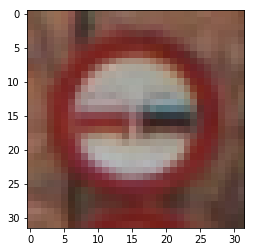

In [300]:
pl1 = plt.imshow(mx.nd.transpose(test_images32_t[i], (1, 2, 0)).asnumpy())

/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


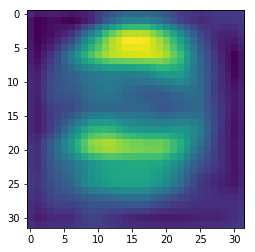

In [302]:
pl2 = plt.imshow(skimage.transform.resize((cam_list[i][31]/mx.nd.max(mx.nd.abs(cam_list[i][31]))).asnumpy(), (32, 32)))

In [303]:
fig, ax = plt.subplots(4, 4)
plt.rcParams["figure.figsize"] = [20,20]
for e, idx in enumerate(idx_case):
    src_img = src['src_img'][idx]
    src_lbl = src['src_lbl'][idx]
    img, lbl = load_data(src_img,src_lbl)
    ax[int(e/4),e%4].imshow(img)
    ax[int(e/4),e%4].imshow(lbl,alpha=0.3)
plt.show()

/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


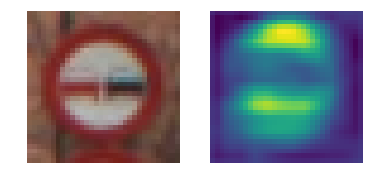

In [268]:
i = 25
plt.subplot(1, 2, 1)  # 3 rows, 8 per row
plt.axis('off')
plt.imshow(mx.nd.transpose(test_images32_t[i], (1, 2, 0)).asnumpy())
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(skimage.transform.resize((cam_list[i][31]/mx.nd.max(mx.nd.abs(cam_list[i][31]))).asnumpy(), (32, 32)))

In [294]:
image_cam = [test_images32, cam_list]

/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


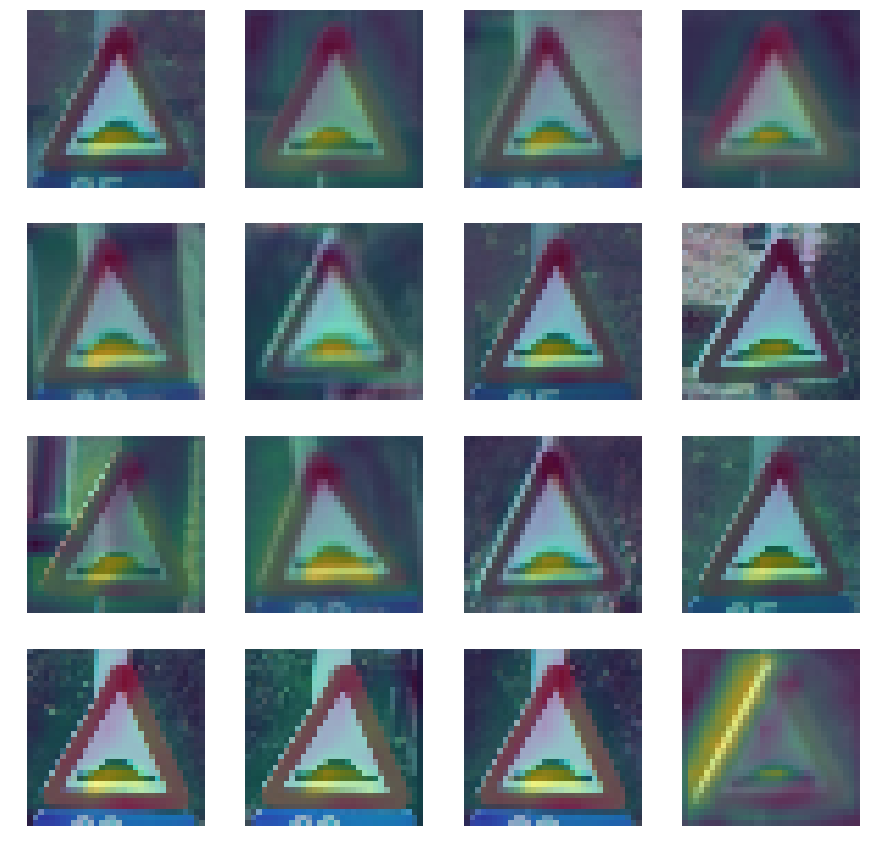

In [346]:
def display_cam_images(images, label, alpha):
    """Display images of a specific label."""
    limit = 16  # show a max of 24 images
    #plt.figure(figsize=(15, 5))
    i = 1

    start = test_labels.asnumpy().tolist().index(label)
    end = start + test_labels.asnumpy().tolist().count(label)
    #for image in test_images32[start:end][:limit]:
    fig = plt.figure(figsize=(15, 15), frameon=False)
    #ax = plt.subplot(3, 8)
    for i in range(min(limit, end - start)):
        img = images[0][start + i]
        cam = images[1][start + i][label]
        cam = skimage.transform.resize((cam/mx.nd.max(mx.nd.abs(cam))).asnumpy(), (32, 32))
        plt.subplot(4, 4, i+1)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        pl1 = plt.imshow(img)
        pl2 = plt.imshow(cam, alpha = alpha)
    plt.show()

display_cam_images(image_cam, 1, 0.5)